## 作業
在鐵達尼資料集中，今天我們專注觀察變數之間的相關性，以Titanic_train.csv 中，首先將有遺失值的數值刪除，並回答下列問題。
* Q1: 透過數值法計算  Age 和  Survived  是否有相關性?
* Q2:透過數值法計算  Sex 和 Survived  是否有相關性?
* Q3: 透過數值法計算  Age 和  Fare 是否有相關性?   
* 提示:    
1.產稱一個新的變數 Survived_cate ，資料型態傳換成類別型態      
2.把題目中的 Survived 用 Survived_cate 來做分析       
3.首先觀察一下這些變數的資料型態後，再來想要以哪一種判斷倆倆的相關性。     


In [1]:
# import library
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import math
import statistics
import seaborn as sns
from IPython.display import display

import pingouin as pg
import researchpy   
%matplotlib inline

## 讀入資料

In [2]:
df_train = pd.read_csv("Titanic_train.csv")
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


In [3]:
## 這邊我們做一個調整，把 Survived 變成離散型變數 Survived_cate
df_train['Survived_cate'] = df_train['Survived'].astype('category')
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived_cate
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


###  Q1: 透過數值法計算  Age 和  Survived  是否有相關性?


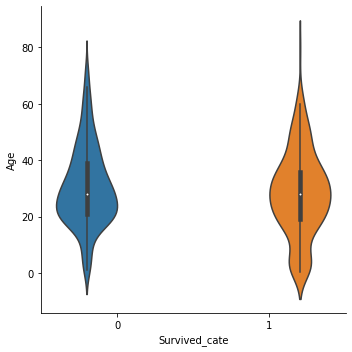

In [4]:
sns.catplot(x='Survived_cate', y='Age', 
            hue='Survived_cate', 
            data=df_train, 
            kind="violin")

###  運用 pg.anova 計算三種變異數

In [5]:
aov = pg.anova(dv='Age', between='Survived_cate', data=df_train, detailed=True)
aov

,Source,SS,DF,MS,F,p-unc,np2
0,Survived_cate,897.187582,1,897.187582,4.271195,0.039125,0.005963
1,Within,149559.448362,712,210.055405,NaN,NaN,NaN


In [6]:
print( '組間變異數 = ', aov.SS[0] )
print( '組內變異數 = ', aov.SS[1] )
print( '總變異數 = ', aov.SS[0]+aov.SS[1] )

組間變異數 =  897.1875816713222
組內變異數 =  149559.44836244633
總變異數 =  150456.63594411765


### Step3:變異數換算得到 Eta Squared (𝜼^𝟐)

In [7]:
etaSq = aov.SS[0] / (aov.SS[0] + aov.SS[1])
etaSq

0.0059630974469252

In [8]:
def judgment_etaSq(etaSq):
    if etaSq < .01:
        qual = 'Negligible'
    elif etaSq < .06:
        qual = 'Small'
    elif etaSq < .14:
        qual = 'Medium'
    else:
        qual = 'Large'
    return(qual)
judgment_etaSq(etaSq)

'Negligible'

### Q2:透過數值法計算  Sex 和 Survived  是否有相關性?


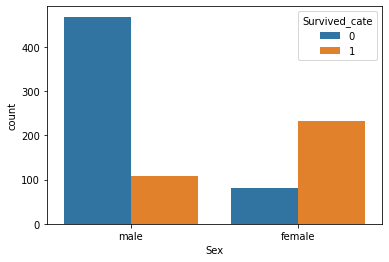

In [9]:
g= sns.countplot(x="Sex", hue="Survived_cate", data=df_train)

## step1: 用交叉列連表(contingency table)，來整理兩個類別型的資料

In [10]:
contTable = pd.crosstab(df_train['Sex'], df_train['Survived_cate'])
contTable

Survived_cate,0,1
Sex,,
female,81,233
male,468,109


## Step2:計算資料自由度 df*

In [11]:
df = min(contTable.shape[0], contTable.shape[1]) - 1
df

1

## Step3:運用 researchpy 套件，計算出 Cramer’s V 係數

In [12]:
crosstab, res = researchpy.crosstab(df_train['Sex'], df_train['Survived_cate'], test='chi-square')
print(res)
print("Cramer's value is",res.loc[2,'results'])

#這邊用卡方檢定獨立性，所以採用的 test 參數為卡方 "test =" argument.
# 採用的變數在這個模組中，會自己根據資料集來判斷，Cramer's Phi if it a 2x2 table, or Cramer's V is larger than 2x2.

                Chi-square test   results
0  Pearson Chi-square ( 1.0) =   263.0506
1                    p-value =     0.0000
2               Cramer's phi =     0.5434
Cramer's value is 0.5434


In [13]:
## 寫一個副程式判斷相關性的強度
def judgment_CramerV(df,V):
    if df == 1:
        if V < 0.10:
            qual = 'negligible'
        elif V < 0.30:
            qual = 'small'
        elif V < 0.50:
            qual = 'medium'
        else:
            qual = 'large'
    elif df == 2:
        if V < 0.07:
            qual = 'negligible'
        elif V < 0.21:
            qual = 'small'
        elif V < 0.35:
            qual = 'medium'
        else:
            qual = 'large'
    elif df == 3:
        if V < 0.06:
            qual = 'negligible'
        elif V < 0.17:
            qual = 'small'
        elif V < 0.29:
            qual = 'medium'
        else:
            qual = 'large'
    elif df == 4:
        if V < 0.05:
            qual = 'negligible'
        elif V < 0.15:
            qual = 'small'
        elif V < 0.25:
            qual = 'medium'
        else:
            qual = 'large'
    else:
        if V < 0.05:
            qual = 'negligible'
        elif V < 0.13:
            qual = 'small'
        elif V < 0.22:
            qual = 'medium'
        else:
            qual = 'large'
    return(qual)

judgment_CramerV(df,res.loc[2,'results'])

'large'

### Q3: 透過數值法計算  Age 和  Fare 是否有相關性?  

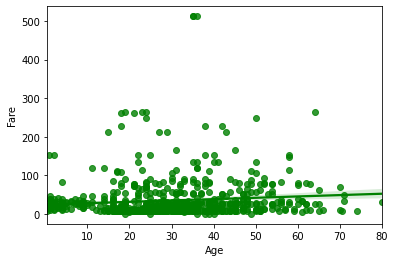

In [14]:
g = sns.regplot(x=df_train['Age'], y=df_train['Fare'], data=df_train, color='g')

In [15]:
data = df_train[['Age', 'Fare']].dropna()

# 由於 pearsonr 有兩個回傳結果，我們只需取第一個回傳值為相關係數
corr, _=stats.pearsonr(data['Age'], data['Fare'])
print(corr)

0.09606669176903891
